In [19]:
import os 
import random
import torch
import numpy as np
import copy 
import json
import argparse 
import glob 
import argparse
import json

from torch import nn
from torch.utils.data import TensorDataset
from attrdict import AttrDict
from scipy.stats import pearsonr, spearmanr
from seqeval import metrics as seqeval_metrics
from sklearn import metrics as sklearn_metrics
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# from fastprogress.fastprogress import master_bar, progress_bar
from transformers import (
    AdamW,
    get_linear_schedule_with_warmup
)
from src import (
    CONFIG_CLASSES,
    TOKENIZER_CLASSES,
    MODEL_FOR_REGRESSION,
    set_seed
)

from processor import seq_reg_load_and_cache_examples as load_and_cache_examples  
from processor import seq_reg_processors as processors
from processor import seq_reg_output_modes as output_modes

### 회귀 모델 3개 이용 

In [20]:
task = 'wellness' 
config_dir = '/home/ubuntu/chatbot/code/config/'
config_file = 'koelectra-base.json'

with open(os.path.join(config_dir, task, config_file)) as f:
    args = AttrDict(json.load(f))

args.output_dir = os.path.join(args.ckpt_dir, args.output_dir)
set_seed(args) 

In [5]:
file_to_read = '/home/ubuntu/chatbot/dataset/Wellness_KATQN_train.tsv'

with open(file_to_read, "r", encoding="utf-8") as f:
    lines = []
    for line in f:
        tmp = line.strip(',') 
        lines.append(tmp[:-1]) 

examples = [] 
set_type = 'train'

for (i, line) in enumerate(lines[1:]):
    line = line.split("\t")
    guid = "%s-%s" % (set_type, i)
    text_a = line[1]
    label = int(line[2])

text_a, label

('10', 10)

In [22]:
processor = processors[args.task](args) 
processor.get_examples('train')

[{
   "guid": "train-0",
   "label": "70",
   "text_a": "\ubb34\ub9ac\ud55c \uac83\ub3c4 \uc544\ub2cc\ub370 \ubab8\uc774 \ucc98\uc9c4\ub2e4",
   "text_b": null
 },
 {
   "guid": "train-1",
   "label": "5",
   "text_a": "\uc774\ub7f4 \uac70\uba74 \uc65c \ub098\ub97c \ub0b3\uc740 \uac74\uc9c0.. \ubaa8\ub974\uaca0\uc5b4.",
   "text_b": null
 },
 {
   "guid": "train-2",
   "label": "70",
   "text_a": "\uc18c\ud654\uac00 \uc548 \ub418\ub2c8\uae4c \uc8fd\uc5b4\ubc84\ub9ac\uace0 \uc2f6\uc5b4",
   "text_b": null
 },
 {
   "guid": "train-3",
   "label": "10",
   "text_a": "\uadf8 \ub2f9\uc2dc\uc5d0 \uc81c\uac00 \uc544\uc8fc \uc8fd\uace0 \uc2f6\uc5c8\ub2e4\ub294 \uac83\ubc16\uc5d0\ub294 \uc0dd\uac01\uc774 \uc548 \ub098\uc694.",
   "text_b": null
 },
 {
   "guid": "train-4",
   "label": "90",
   "text_a": "\uc9d1\uc911\ub825\uc774 \uc810\uc810 \ub5a8\uc5b4\uc9c0\uace0 \uc788\uc5b4\uc694",
   "text_b": null
 },
 {
   "guid": "train-5",
   "label": "70",
   "text_a": "\uc2ac\ub7fc\ud504 \ub54c\ubb3

In [23]:
args.model_name_or_path

'monologg/koelectra-base-discriminator'

In [24]:
config = CONFIG_CLASSES[args.model_type].from_pretrained(   
        args.model_name_or_path
)

# config2

In [25]:
config

ElectraConfig {
  "architectures": [
    "ElectraForPreTraining"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "embedding_size": 768,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "electra",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "summary_activation": "gelu",
  "summary_last_dropout": 0.1,
  "summary_type": "first",
  "summary_use_proj": true,
  "transformers_version": "4.21.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32200
}

In [26]:
tokenizer = TOKENIZER_CLASSES[args.model_type].from_pretrained(   # model_type: koelectra-base, ElectraTokenizer 
    args.model_name_or_path,
    do_lower_case = args.do_lower_case,
)

model = MODEL_FOR_REGRESSION[args.model_type].from_pretrained(
    args.model_name_or_path,
    config=config
)

Some weights of the model checkpoint at monologg/koelectra-base-discriminator were not used when initializing ElectraModel: ['discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense_prediction.weight']
- This IS expected if you are initializing ElectraModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
model

ElectraModel(
  (embeddings): ElectraEmbeddings(
    (word_embeddings): Embedding(32200, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): ElectraEncoder(
    (layer): ModuleList(
      (0): ElectraLayer(
        (attention): ElectraAttention(
          (self): ElectraSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): ElectraSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inpl

In [28]:
class ElectraRegressor(nn.Module):
    def __init__(self, electra, config):
        # 부모 생성자 초기화 
        # super().__init__(config) 시 오류 발생 
        super(ElectraRegressor, self).__init__() 
        self.electra = electra
        self.cls_layer = nn.Linear(config.hidden_size, 128)
        self.regressor = nn.Sequential(nn.Dropout(0.1), nn.Linear(128, 1))
        # self.relu1 = nn.ReLU()
        # self.fc1 = nn.Linear(128, 128)
        # self.tanh = nn.Tanh()
        # self.fc2 = nn.Linear(128, 1)
    
    def forward(self, input_ids, attention_mask, token_type_ids):
        outputs = self.electra(input_ids=input_ids,
                               attention_mask=attention_mask,
                               token_type_ids=token_type_ids)
        logits = outputs.last_hidden_state[:, 0, :]
        # print(f'logits: {len(logits)}')
        output = self.cls_layer(logits)
        output = self.regressor(output)
        # output = self.fc1(output)
        # output = self.tanh(output)
        # output = self.fc2(output)
        return output

In [29]:
args.device = "cuda" if torch.cuda.is_available() and not args.no_cuda else "cpu"
electra_model = ElectraRegressor(model, config=config).to(args.device)

In [30]:
electra_model

ElectraRegressor(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32200, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-

In [31]:
def train(args, model, train_dataset, val_dataset=None, test_dataset=None):
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args.train_batch_size)
    eval_sampler = SequentialSampler(val_dataset)
    eval_dataloader = DataLoader(val_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    global_step = 0
    nb_eval_steps = 0
    train_mse = []
    eval_mse = [] 
    t_total = len(train_dataloader) // args.gradient_accumulation_steps * args.num_train_epochs

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': args.weight_decay},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args.learning_rate, eps=args.adam_epsilon)
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * args.warmup_proportion), num_training_steps=t_total)

    model.zero_grad()
    for epoch in range(int(args.num_train_epochs)):
        tr_loss = 0.0
        eval_loss = 0.0
        model.train()
        # epoch_iterator = progress_bar(train_dataloader, parent=mb)
        for step, batch in enumerate(train_dataloader):
            optimizer.zero_grad()
            batch = tuple(t.to(args.device) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                # "labels": batch[3]
            }
            # print(batch[3])
            outputs = model(**inputs)
            #print(np.shape(outputs.squeeze()))
            #print(f'input_ids: {len(batch[0][0])}, attention_mask: {len(batch[1][0])}, \
            #token_type_ids: {len(batch[2][0])}')
            #print('-'*20)
            #print(f'input_ids: {len(batch[0])}, attention_mask: {len(batch[1])}, \
            #token_type_ids: {len(batch[2])}, labels: {len(batch[3])}')
            #print('-')
            #print(f'input_ids: {batch[0][0]}, attention_mask: {batch[1][0]}, token_type_ids: {batch[2][0]}, labels: {batch[3]}')
            criterion = nn.MSELoss()  # criterion = nn.MSELoss()
            loss = criterion(outputs.squeeze(), batch[3].type_as(outputs))
            print(f'outputs: {outputs.squeeze(), batch[3].type_as(outputs)}')
            # output = loss(batch[3], outputs[1])
            # output.backward()
            loss.backward()
            tr_loss += loss.item()
            torch.nn.utils.clip_grad_norm_(model.parameters(), args.max_grad_norm)
            optimizer.step() 
            scheduler.step()
            
        # mb.write("Epoch {} done".format(epoch + 1))
        print(f'Epoch {epoch + 1} done, tr_loss: {tr_loss / len(train_dataloader)}')
        train_mse.append(tr_loss / len(train_dataloader))
        
        for batch in eval_dataloader:
            model.eval()
            batch = tuple(t.to(args.device) for t in batch)

            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                    # "labels": batch[3]
                }
                outputs = model(**inputs)
                tmp_eval_loss = criterion(outputs.squeeze(), batch[3].type_as(outputs))
                eval_loss += tmp_eval_loss.mean().item()

            nb_eval_steps += 1
        eval_loss = eval_loss / nb_eval_steps
        eval_mse.append(eval_loss)
    return train_mse, eval_mse 

In [32]:
def evaluate(args, model, eval_dataset, mode, global_step=None):
    results = {}
    eval_sampler = SequentialSampler(eval_dataset)
    eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args.eval_batch_size)

    eval_loss = 0.0
    nb_eval_steps = 0
    preds = None
    out_label_ids = None

    for batch in eval_dataloader:
        model.eval()
        batch = tuple(t.to(args.device) for t in batch)

        with torch.no_grad():
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "labels": batch[3]
            }
            if args.model_type not in ["distilkobert", "xlm-roberta"]:
                inputs["token_type_ids"] = batch[2]  # Distilkobert, XLM-Roberta don't use segment_ids
            outputs = model(**inputs)
            tmp_eval_loss, logits = outputs[:2]
            print(f'outputs: {outputs}')
            eval_loss += tmp_eval_loss.mean().item()
        nb_eval_steps += 1
        if preds is None:
            preds = logits.detach().cpu().numpy()
            out_label_ids = inputs["labels"].detach().cpu().numpy()
        else:
            preds = np.append(preds, logits.detach().cpu().numpy(), axis=0)
            out_label_ids = np.append(out_label_ids, inputs["labels"].detach().cpu().numpy(), axis=0)

    eval_loss = eval_loss / nb_eval_steps
    preds = np.argmax(preds, axis=1)
    return 

In [33]:
train_dataset = load_and_cache_examples(args, tokenizer, mode="train") if args.train_file else None
dev_dataset = load_and_cache_examples(args, tokenizer, mode="dev") if args.dev_file else None
test_dataset = load_and_cache_examples(args, tokenizer, mode="test") if args.test_file else None

if dev_dataset == None:
    args.evaluate_test_during_training = True  # If there is no dev dataset, only use testset

if args.do_train:
    train_loss3, eval_loss3 = train(args, electra_model, train_dataset, dev_dataset, test_dataset)

KeyError: '70'

In [176]:
torch.cuda.empty_cache()

#### 학습 모델 저장 (label_0, 1, 2에 대해 총 3개 모델 저장)

In [186]:
model_path = '/home/ubuntu/chatbot/code/model/'
model_name = 'KoELECTRA_label2_50.pt'

In [187]:
torch.save(electra_model.state_dict(), os.path.join(model_path, model_name))

In [188]:
len(train_loss), len(eval_loss)  

(50, 50)

In [189]:
len(train_loss2), len(eval_loss2)

(50, 50)

In [190]:
len(train_loss3), len(eval_loss3)

(50, 50)

In [191]:
train_loss[:5], train_loss2[:5]

([772.8231004185501,
  611.5520064950388,
  490.43624798828944,
  488.2821599265006,
  434.8644574780927],
 [1096.9064809741783,
  778.4333566518931,
  557.9103478779363,
  523.3704314088343,
  576.8520503857462])

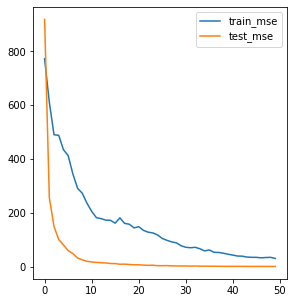

In [192]:
import matplotlib.pyplot as plt 

epochs_50 = list(range(0, 50))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(list(range(len(train_loss))), train_loss, label='train_mse')
plt.plot(list(range(len(eval_loss))), eval_loss, label='test_mse')

plt.legend()
plt.show()

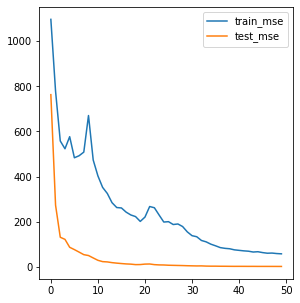

In [193]:
import matplotlib.pyplot as plt 

epochs_50 = list(range(0, 50))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(list(range(len(train_loss2))), train_loss2, label='train_mse')
plt.plot(list(range(len(eval_loss2))), eval_loss2, label='test_mse')

plt.legend()
plt.show()

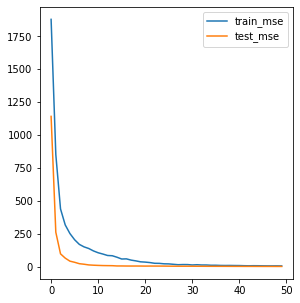

In [194]:
import matplotlib.pyplot as plt 

epochs_50 = list(range(0, 50))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(list(range(len(train_loss3))), train_loss3, label='train_mse')
plt.plot(list(range(len(eval_loss3))), eval_loss3, label='test_mse')

plt.legend()
plt.show()

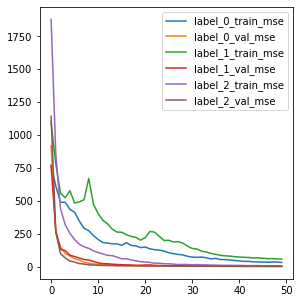

In [195]:
import matplotlib.pyplot as plt 

epochs_50 = list(range(0, 50))
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

plt.plot(list(range(len(train_loss))), train_loss, label='label_0_train_mse')
plt.plot(list(range(len(eval_loss))), eval_loss, label='label_0_val_mse')
plt.plot(list(range(len(train_loss2))), train_loss2, label='label_1_train_mse')
plt.plot(list(range(len(eval_loss2))), eval_loss2, label='label_1_val_mse')
plt.plot(list(range(len(train_loss3))), train_loss3, label='label_2_train_mse')
plt.plot(list(range(len(eval_loss3))), eval_loss3, label='label_2_val_mse')

plt.legend()
plt.show()

In [196]:
train_loss

[772.8231004185501,
 611.5520064950388,
 490.43624798828944,
 488.2821599265006,
 434.8644574780927,
 413.2517222465081,
 345.30871746611837,
 291.84705646221454,
 273.2715909760134,
 236.26399146115102,
 206.0097859998212,
 182.68990837530947,
 178.9109993108539,
 173.31270002920093,
 172.68905768506104,
 162.09778359582194,
 181.86584856039704,
 161.31238839777816,
 158.1131588352165,
 144.59443213548948,
 149.09711532210028,
 135.34380668461523,
 128.6349981556768,
 125.79945226178121,
 118.37369502268507,
 105.3681675072099,
 98.30302238464355,
 92.4668271629308,
 89.02329974987833,
 78.17587971767055,
 72.50718496954163,
 70.77371084411008,
 72.41921055516272,
 67.11192991901002,
 59.02904622929551,
 62.53417204534728,
 53.90817877281469,
 53.270173758567374,
 50.45254550091798,
 46.57645243226884,
 43.448093838516286,
 39.967972701209845,
 39.488960822689094,
 36.14842893606843,
 35.28290027439794,
 35.13329621860415,
 33.41239726663034,
 34.415997481266395,
 35.22298966761816,
 

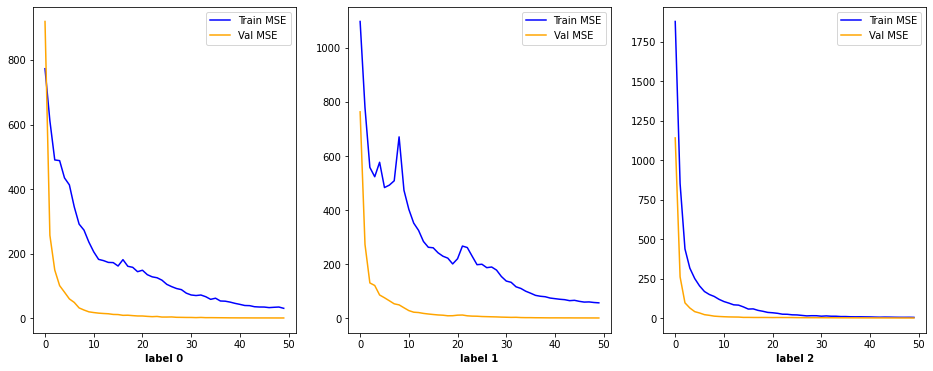

In [197]:
import matplotlib.pyplot as plt 

f, ax = plt.subplots(1, 3, figsize=(16, 6))
epochs_50 = list(range(0, 50))
idx = 0 

ax[0].plot(epochs_50, train_loss, color='blue', label='Train MSE')
ax[0].plot(epochs_50, eval_loss, color='orange', label='Val MSE')
ax[0].set_xlabel(f'label 0', fontweight='bold')
ax[0].legend()

ax[1].plot(epochs_50, train_loss2, color='blue', label='Train MSE')
ax[1].plot(epochs_50, eval_loss2, color='orange', label='Val MSE')
ax[1].set_xlabel(f'label 1', fontweight='bold')
ax[1].legend()

ax[2].plot(epochs_50, train_loss3, color='blue', label='Train MSE')
ax[2].plot(epochs_50, eval_loss3, color='orange', label='Val MSE')
ax[2].set_xlabel(f'label 2', fontweight='bold')
ax[2].legend()

plt.show()

### 다중 출력 회귀 모델 이용 

In [ ]:
class InputExample(object):
    """
    A single training/test example for simple sequence classification.
    """
    def __init__(self, guid, text_a, text_b, label):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

In [ ]:
class InputFeatures(object):
    """A single set of features of data."""

    def __init__(self, input_ids, attention_mask, token_type_ids, label):
        self.input_ids = input_ids
        self.attention_mask = attention_mask
        self.token_type_ids = token_type_ids
        self.label = label

    def __repr__(self):
        return str(self.to_json_string())

    def to_dict(self):
        """Serializes this instance to a Python dictionary."""
        output = copy.deepcopy(self.__dict__)
        return output

    def to_json_string(self):
        """Serializes this instance to a JSON string."""
        return json.dumps(self.to_dict(), indent=2, sort_keys=True) + "\n"

In [ ]:
class WellnessProcessor(object):
    """Processor for the Wellness data set """
    def __init__(self, args):
        self.args = args

    def get_labels(self):
        label_list = list(range(19))
        label_list = list(map(str, label_list)) 
        return label_list 

    @classmethod
    def _read_file(cls, input_file):
        """
        Reads a tab separated value file (csv).
        f: data/wellness/Wellness_Conversation_intent_train.tsv 
        """
        with open(input_file, "r", encoding="utf-8") as f:
            lines = []
            for line in f:
                tmp = line.strip(',') 
                lines.append(tmp[:-1]) 
            return lines

    def _create_examples(self, lines, set_type):
        """Creates examples for the training and dev sets."""
        examples = []
        for (i, line) in enumerate(lines[1:]):
            line = line.split("\t")
            guid = "%s-%s" % (set_type, i)
            text_a = line[2]
            label = line[3]
            examples.append(InputExample(guid=guid, text_a=text_a, text_b=None, label=label))
        return examples

    def get_examples(self, mode):
        """
        Args:
            mode: train, dev, test
        """
        file_to_read = None
        if mode == "train":
            file_to_read = self.args['train_file']
        elif mode == "dev":
            file_to_read = self.args['dev_file']
        elif mode == "test":
            file_to_read = self.args['test_file']

        return self._create_examples(
            self._read_file(file_to_read), mode
        )

In [75]:
def seq_cls_convert_examples_to_features(args, examples, tokenizer, max_length, task):
    processor = WellnessProcessor(args)
    label_list = processor.get_labels()
    output_mode = "regression"
    label_map = {label: i for i, label in enumerate(label_list)}

    def label_from_example(example):
        if output_mode == "classification":
            return label_map[example.label]
        elif output_mode == "regression":
            return float(example.label)
        
    labels = [label_from_example(example) for example in examples]
    batch_encoding = tokenizer.batch_encode_plus(
        [(example.text_a, example.text_b) for example in examples],
        max_length=max_length,
        padding="max_length",
        add_special_tokens=True,
        truncation=True,
    )

    features = []
    for i in range(len(examples)):
        inputs = {k: batch_encoding[k][i] for k in batch_encoding}
        if "token_type_ids" not in inputs:
            inputs["token_type_ids"] = [0] * len(inputs["input_ids"])  # For xlm-roberta
        feature = InputFeatures(**inputs, label=labels[i])
        features.append(feature)
    return features

In [ ]:
def seq_cls_load_and_cache_examples(args, tokenizer, mode):
    processor = WellnessProcessor(args)   
    output_mode = "regression" 
    # Load data features from cache or dataset file

    if mode == "train":
        examples = processor.get_examples("train")
    elif mode == "dev":
        examples = processor.get_examples("dev")
    elif mode == "test":
        examples = processor.get_examples("test")
    else:
        raise ValueError("For mode, only train, dev, test is avaiable")

    features = seq_cls_convert_examples_to_features(
            args, examples, tokenizer, max_length=args['max_seq_len'], task='wellness'
      )
    
    # Convert to Tensors and build dataset
    all_input_ids = torch.tensor([f.input_ids for f in features], dtype=torch.long)
    all_attention_mask = torch.tensor([f.attention_mask for f in features], dtype=torch.long)
    all_token_type_ids = torch.tensor([f.token_type_ids for f in features], dtype=torch.long)
    if output_mode == "classification":
        all_labels = torch.tensor([f.label for f in features], dtype=torch.long)
    elif output_mode == "regression":
        all_labels = torch.tensor([f.label for f in features], dtype=torch.float)

    dataset = TensorDataset(all_input_ids, all_attention_mask, all_token_type_ids, all_labels)
    return dataset

In [ ]:
def set_seed(args):
    random.seed(args['seed'])
    np.random.seed(args['seed'])
    torch.manual_seed(args['seed'])
    if not args['no_cuda'] and torch.cuda.is_available():
        torch.cuda.manual_seed_all(args['seed'])

In [ ]:
processor = WellnessProcessor(config)
labels = processor.get_labels()
# labels

In [ ]:
config2 = ElectraConfig.from_pretrained(   # ElectraConfig.from_pretrained
        config['model_name_or_path'],
        num_labels = 19,   # args.task: wellness, num_labels = 19 
        id2label={str(i): label for i, label in enumerate(labels)},   # labels: ['0', '1', '2', ... ,'18']
        label2id={label: i for i, label in enumerate(labels)},
)

# config2

In [ ]:
tokenizer = ElectraTokenizer.from_pretrained(   # model_type: koelectra-base, ElectraTokenizer 
    config['model_name_or_path'],
    do_lower_case = config['do_lower_case'],
)

model = ElectraForSequenceClassification.from_pretrained(
    config['model_name_or_path'],
    config=config2
)

Some weights of the model checkpoint at monologg/koelectra-base-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense.bias', 'discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at monologg/koelectra-base-discriminator and are newly initialized: ['clas

In [ ]:
config['device'] = "cuda" if torch.cuda.is_available() and not config['no_cuda'] else "cpu"
model.to(config['device'])

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(32200, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0): ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm

In [ ]:
def calc_accuracy(X,Y):
    # print('acc:', len(X), len(Y), type(X), type(Y))
    max_vals, max_indices = torch.max(X, 1)
    # print('acc2:', max_vals, max_indices)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc

In [ ]:
def simple_accuracy(labels, preds):
    return (labels == preds).mean()

def acc_score(labels, preds):
    return {
        "acc": simple_accuracy(labels, preds),
    }

def pearson_and_spearman(labels, preds):
    pearson_corr = pearsonr(preds, labels)[0]
    spearman_corr = spearmanr(preds, labels)[0]
    return {
        "pearson": pearson_corr,
        "spearmanr": spearman_corr,
        "corr": (pearson_corr + spearman_corr) / 2,
    }

def f1_pre_rec(labels, preds, is_ner=True):
    if is_ner:
        return {
            "precision": seqeval_metrics.precision_score(labels, preds, suffix=True),
            "recall": seqeval_metrics.recall_score(labels, preds, suffix=True),
            "f1": seqeval_metrics.f1_score(labels, preds, suffix=True),
        }
    else:
        return {
            "precision": sklearn_metrics.precision_score(labels, preds, average="macro"),
            "recall": sklearn_metrics.recall_score(labels, preds, average="macro"),
            "f1": sklearn_metrics.f1_score(labels, preds, average="macro"),
        }

In [126]:
def train(args, model, train_dataset, val_dataset=None, test_dataset=None):
    train_acc_50 = []
    train_sampler = RandomSampler(train_dataset)
    train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])
    eval_sampler = SequentialSampler(test_dataset)
    eval_dataloader = DataLoader(test_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

    eval_loss = 0.0
    nb_eval_steps = 0
    eval_acc_50 = []

    t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']

    # Prepare optimizer and schedule (linear warmup and decay)
    no_decay = ['bias', 'LayerNorm.weight']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
         'weight_decay': args['weight_decay']},
        {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
    optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(t_total * args['warmup_proportion']), num_training_steps=t_total)
    global_step = 0
    tr_loss = 0.0

    model.zero_grad()
    mb = master_bar(range(int(args['num_train_epochs'])))
    for epoch in mb:
        train_acc = 0.0
        eval_acc = 0.0
        epoch_iterator = progress_bar(train_dataloader, parent=mb)
        for step, batch in enumerate(epoch_iterator):
            model.train()
            batch = tuple(t.to(args['device']) for t in batch)
            inputs = {
                "input_ids": batch[0],
                "attention_mask": batch[1],
                "token_type_ids": batch[2],
                "labels": batch[3]
            }
            outputs = model(**inputs)
            loss = outputs[0]
            loss.backward()
            tr_loss += loss.item()
            train_acc += calc_accuracy(outputs[1], batch[3])
            # print(f'train_acc: {train_acc / (step + 1)}')
            if (step + 1) % args['gradient_accumulation_steps'] == 0 or (
                    len(train_dataloader) <= args['gradient_accumulation_steps']
                    and (step + 1) == len(train_dataloader)
            ):
                torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])
                optimizer.step()
                scheduler.step()
                model.zero_grad()
                global_step += 1
                
                if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
                    if args['evaluate_test_during_training']:
                        evaluate(args, model, test_dataset, "test", global_step)
                    else:
                        evaluate(args, model, dev_dataset, "dev", global_step)
        mb.write("Epoch {} done".format(epoch + 1))
        train_acc_50.append(train_acc / (step + 1))   

        for batch in progress_bar(eval_dataloader):
            model.eval()
            batch = tuple(t.to(args['device']) for t in batch)

            with torch.no_grad():
                inputs = {
                    "input_ids": batch[0],
                    "attention_mask": batch[1],
                    "token_type_ids": batch[2],
                    "labels": batch[3]
                }
                outputs = model(**inputs)
                tmp_eval_loss, logits = outputs[:2]
                eval_loss += tmp_eval_loss.mean().item()
                eval_acc += calc_accuracy(outputs[1], batch[3]) 

            nb_eval_steps += 1
        eval_loss = eval_loss / nb_eval_steps
        eval_acc_50.append(eval_acc / (nb_eval_steps + 1))

    return train_acc_50, eval_acc_50

In [124]:
def compute_metrics(task_name, labels, preds):
    assert len(preds) == len(labels)
    return acc_score(labels, preds)

In [125]:
train_dataset = seq_cls_load_and_cache_examples(config, tokenizer, mode="train") if config['train_file'] else None
dev_dataset = seq_cls_load_and_cache_examples(config, tokenizer, mode="dev") if config['dev_file'] else None
test_dataset = seq_cls_load_and_cache_examples(config, tokenizer, mode="test") if config['test_file'] else None

if dev_dataset == None:
    config['evaluate_test_during_training'] = True  # If there is no dev dataset, only use testset

if config['do_train']:
    train_acc, test_acc = train(config, model, train_dataset, dev_dataset, test_dataset)

TypeError: forward() got an unexpected keyword argument 'labels'